In [282]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [263]:
data = pd.read_csv("dataset.csv")

In [264]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [265]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [266]:
# Clean TotalCharges where empty value

data.loc[data["tenure"] == 0, "TotalCharges"] = data.loc[data["tenure"] == 0, "tenure"] * data.loc[data["tenure"] == 0, "MonthlyCharges"]
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"])

In [267]:
for i in data.columns:
    if data[i].dtype == "object":
        print(f"{i}: {data[i].unique()}")

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [268]:
# Make all categorical data numerical

data["gender"] = (data["gender"].str.lower() == "male").astype(int)
data["Partner"] = (data["Partner"].str.lower() == "yes").astype(int)
data["Dependents"] = (data["Dependents"].str.lower() == "yes").astype(int)
data["PhoneService"] = (data["PhoneService"].str.lower() == "yes").astype(int)
data["MultipleLines"]  = data["MultipleLines"].str.lower().map({"no phone service": 0, "yes": 1, "no": 2})
data["InternetService"]  = data["InternetService"].str.lower().map({"dsl": 0, "fiber optic": 1, "no": 2})
data["OnlineSecurity"]  = data["OnlineSecurity"].str.lower().map({"no internet service": 0, "yes": 1, "no": 2})
data["OnlineBackup"]  = data["OnlineBackup"].str.lower().map({"no internet service": 0, "yes": 1, "no": 2})
data["DeviceProtection"]  = data["DeviceProtection"].str.lower().map({"no internet service": 0, "yes": 1, "no": 2})
data["TechSupport"]  = data["TechSupport"].str.lower().map({"no internet service": 0, "yes": 1, "no": 2})
data["StreamingTV"]  = data["StreamingTV"].str.lower().map({"no internet service": 0, "yes": 1, "no": 2})
data["StreamingMovies"]  = data["StreamingMovies"].str.lower().map({"no internet service": 0, "yes": 1, "no": 2})
data["Contract"] = data["Contract"].str.lower().map({"month-to-month": 0, "one year": 1, "two year": 2})
data["PaperlessBilling"] = (data["PaperlessBilling"].str.lower() == "yes").astype(int)
data["PaymentMethod"] = data["PaymentMethod"].str.lower().map({"electronic check": 0, "mailed check": 1, "bank transfer (automatic)": 2, "credit card (automatic)": 3})

data["Churn"] = (data["Churn"].str.lower() == "yes").astype(int)

In [269]:
# drop customerID as it doesn't influence churn
data.drop(columns=["customerID"], inplace=True)

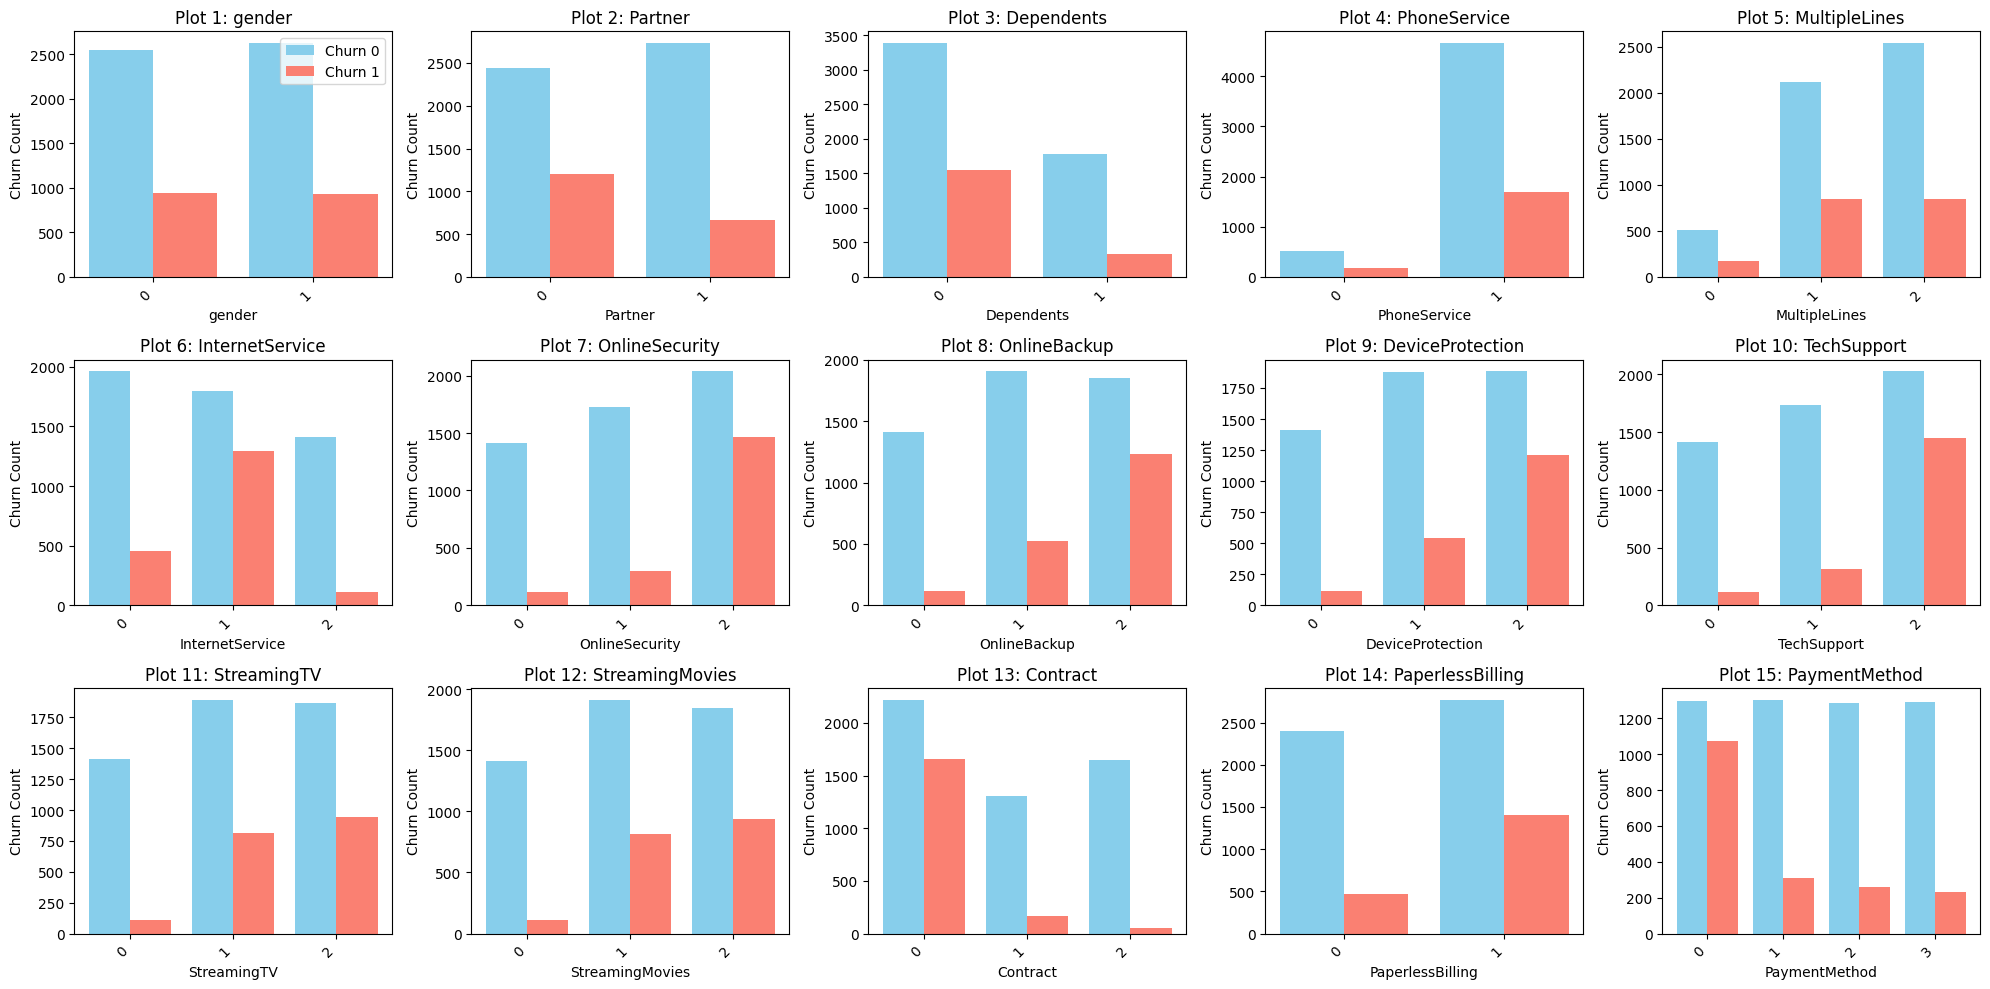

In [ ]:
columns = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"]
fig, axs = plt.subplots(3,5, figsize=(20,10))

for i in range(3):
    for j in range(5):
        curr_col = columns[(i * 5) + j]
        churn_counts = data.groupby([curr_col, "Churn"]).size().unstack()

        ax = axs[i, j]
        categories = churn_counts.index
        churn_classes = churn_counts.columns

        x = np.arange(len(categories))
        bar_width = 0.8 / len(churn_classes)

        for k, churn_value in enumerate(churn_classes):
            ax.bar(
                x + k * bar_width - (bar_width * (len(churn_classes) - 1) / 2),
                churn_counts[churn_value],
                width=bar_width,
                label=f"Churn {churn_value}" if i == 0 and j == 0 else None,
                color=["skyblue", "salmon"][k % 2]
            )

        ax.set_xticks(x)
        ax.set_xticklabels(churn_counts.index, rotation=45, ha="right")

        ax.set_title(f"Plot {i*5 + j + 1}: {curr_col}")
        ax.set_xlabel(curr_col)
        ax.set_ylabel("Churn Count")
        if i == 0 and j == 0:  # Show legend only once
            ax.legend()

plt.tight_layout()
plt.show()

In [271]:
data["tenure"] = (data["tenure"] - data["tenure"].mean()) / data["tenure"].std()
data["MonthlyCharges"] = (data["MonthlyCharges"] - data["MonthlyCharges"].mean()) / data["MonthlyCharges"].std()
data["TotalCharges"] = (data["TotalCharges"] - data["TotalCharges"].mean()) / data["TotalCharges"].std()

In [272]:
y = data["Churn"]
X = data.drop(columns=["Churn"], inplace=False)

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_params = [
    ("Logistic Regression", LogisticRegression(), {
        "C": [0.01, 0.1,1, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs"],
        "max_iter": [10000]
    }),
    ("Random Forest", RandomForestClassifier(), {
        "n_estimators": [100, 200],
        "max_depth": [3, 4, 5, None]
    }),
    ("SVC", SVC(), {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"]
    }),
]

best_models = {}

for name, model, params in model_params:
    grid = GridSearchCV(model, param_grid=params, cv=5, scoring="accuracy")
    grid.fit(X_train, y_train)
    print(f"{name} | Best Params: {grid.best_params_} | Best Score: {grid.best_score_:.4f}")
    best_models[name] = grid.best_estimator_

In [275]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"{name} | Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Logistic Regression | Test Accuracy: 0.8204
Random Forest | Test Accuracy: 0.8006
SVC | Test Accuracy: 0.8162
